In [1]:
import sys 
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from math import log10
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

sys.path.insert(0, '../src')

import models
import util


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# dirs
train_dir = "../data/train"
test_dir = "../data/test"

# crop size of images
crop_size = 128

In [4]:
# create train and test dataset
train_dataset = models.ImageDataset(train_dir)
test_dataset = models.ImageDataset(test_dir)

# batch size
batch_size = 4

# create train and test dataloader
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# model declaration and hyperparameters
model = models.DnCNN().to(device)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr)

KeyboardInterrupt: 

In [ ]:
def gaussian(ins, stddev):  
    # noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    noise = torch.rand(ins.size()).normal_(0, stddev / 255.)
    return (ins + noise), noise

def calc_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * log10(1. / (mse ** .5))

In [ ]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader, 1):
        target = data
        input, noise = gaussian(target, 25)
        
        input = Variable(input.cuda())
        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        
        output = model(input)

        loss = criterion(output, noise)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

In [ ]:
def validate():
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for data in testing_data_loader:
            target = data
            input, noise = gaussian(target, 25)

            input = Variable(input.cuda())
            noise = Variable(noise.cuda())
            target = Variable(target.cuda())

            output = model(input)
            # mse = criterion(output, input)
            # psnr = 10 * log10(1 / mse.item())
            psnr = calc_psnr(output, input)
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

In [ ]:
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
      validate()
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

/home/jonda/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


===> Epoch[1](1/50): Loss: 0.1307
===> Epoch[1](2/50): Loss: 0.1316
===> Epoch[1](3/50): Loss: 0.1335
===> Epoch[1](4/50): Loss: 0.1325
===> Epoch[1](5/50): Loss: 0.1360
===> Epoch[1](6/50): Loss: 0.1381
===> Epoch[1](7/50): Loss: 0.1320
===> Epoch[1](8/50): Loss: 0.1316
===> Epoch[1](9/50): Loss: 0.1323
===> Epoch[1](10/50): Loss: 0.1348
===> Epoch[1](11/50): Loss: 0.1333
===> Epoch[1](12/50): Loss: 0.1269
===> Epoch[1](13/50): Loss: 0.1258
===> Epoch[1](14/50): Loss: 0.1341
===> Epoch[1](15/50): Loss: 0.1300
===> Epoch[1](16/50): Loss: 0.1301
===> Epoch[1](17/50): Loss: 0.1281
===> Epoch[1](18/50): Loss: 0.1322
===> Epoch[1](19/50): Loss: 0.1240
===> Epoch[1](20/50): Loss: 0.1223
===> Epoch[1](21/50): Loss: 0.1255
===> Epoch[1](22/50): Loss: 0.1211
===> Epoch[1](23/50): Loss: 0.1268
===> Epoch[1](24/50): Loss: 0.1284
===> Epoch[1](25/50): Loss: 0.1247
===> Epoch[1](26/50): Loss: 0.1270
===> Epoch[1](27/50): Loss: 0.1269
===> Epoch[1](28/50): Loss: 0.1263
===> Epoch[1](29/50): Loss: 0

In [ ]:
# declare model
model = models.DnCNN().to(device)

# load checkpoint
model = torch.load('model_epoch_10.pth')

# extract model architecture
model = model['arch']

# transformation on test image
loader = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])

# function to load image and convert to tensor
def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    
    return image.cuda()

# generate the clean image (i.e remove noise from image)
def remove_noise(model, image):
    out = torch.clamp(image-model(image), 0., 1.)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    # plt.imshow(trans(out))
    trans(out).save('out.png')
    return trans(out)

/tmp/ipykernel_37713/1316852769.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


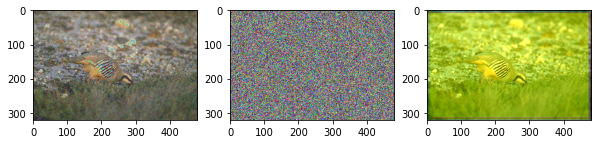

In [ ]:
# transformation on test image
loader = transforms.Compose([
        # transforms.Resize((256,256)),
        transforms.ToTensor(),
    ])

img_path = '../data/test/8023.jpg'
image = Image.open(img_path)
image = loader(image)
image, noise = gaussian(image, 25)
image_pil = transforms.ToPILImage()(image)
fig = plt.figure(figsize=(10,20))
fig.add_subplot(1,3,1)
plt.imshow(image_pil)
fig.add_subplot(1,3,2)
plt.imshow(transforms.ToPILImage()(noise))
# pass the image into the image_loader function
image = image_loader(img_path)
# pre = transforms.ToPILImage()(image)
# plt.imshow(pre)
# get prediction
denoised = remove_noise(model, image)
fig.add_subplot(1,3,3)
plt.imshow(denoised)
fig.show()


In [ ]:
def calc_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * log10(1. / (mse ** .5))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 40, 40] instead

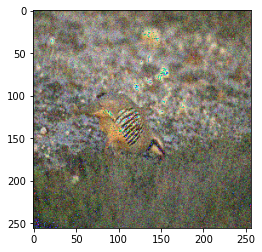

In [ ]:
import random

img_path = '../data/test/8023.jpg'
image = Image.open(img_path)
image = loader(image)
# gauss_img = torch.tensor(random_noise(image, mode='gaussian', mean=0, var=0.025, clip=True))
gauss_img = image + torch.rand(image.shape).normal_(0., 25 / 255.)
# gauss_img = gauss_img.clip(0.,1.)
# gauss_img = transforms.ToPILImage()(gauss_img)
plt.imshow(transforms.ToPILImage()(gauss_img))
# calc_psnr(image,transforms.ToTensor()(gauss_img))
input = np.asarray(transforms.ToPILImage()(gauss_img))
patch_size = 40
H, W = input.shape[:2]
rnd_h = random.randint(0, max(0, H - patch_size))
rnd_w = random.randint(0, max(0, W - patch_size))
patch = input[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :]
model(transforms.PILToTensor()(Image.fromarray(patch)).cuda())
# remove_noise(model, patch)